In [ ]:
# -----------------------------------------------------------------------------
# Autor:       Pedro J. Lancheros / Peter Boat
# Proyecto:    CRSN (crsn-slides-2015-2025)
# Bloque:      #0 - Infraestructura Global y ADN de Diseño
# Fecha:       2026-01-30 | Hora Bogotá: 22:55 (-5 UTC)
# Versión:     v26.46 (Standard: CRSN Branding & Resilient Mount)
# -----------------------------------------------------------------------------

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, timezone
from google.colab import drive
from matplotlib.colors import LinearSegmentedColormap

# 1. MONTAJE RESILIENTE DE DRIVE (Evita ValueError)
if not os.path.exists('/content/drive/MyDrive'):
    try:
        print("📡 Sincronizando Google Drive...")
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        print(f"⚠️ Error en montaje: {e}")
else:
    print("✅ Google Drive ya está vinculado.")

# 2. RUTAS MAESTRAS ABSOLUTAS
BASE_PATH = "/content/drive/MyDrive/01_projects/crsn-slides-actividades-2025"
EXCEL_PATH = os.path.join(BASE_PATH, "vf.ESTADISTICAS_SABANA_NORTE_2015-2025.xlsx")
LOGO_PATH = os.path.join(BASE_PATH, "crsn-logo-dark-circulo.png")

# Trazabilidad Temporal para cada corrida
tz_bog = timezone(timedelta(hours=-5))
TIMESTAMP = datetime.now(tz_bog).strftime("%Y%m%d_%H%M")
OUTPUT_FOLDER = os.path.join(BASE_PATH, f"PRODUCCION_{TIMESTAMP}")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# 3. ADN DE DISEÑO CRSN (BLUEPRINT v26.46)
PHI = 1.61803398875
PJLA_STYLE = {
    "bg": "#000028", "bar": "#000080", "oro": "#FFD700", "white": "#FFFFFF",
    "font": "DejaVu Sans",
    "sizes": {"title": 54, "subtitle": 32, "data": 30, "axis": 18},
    "h_ratio": 7.5 / (PHI**2)
}

# Configuración Global de Matplotlib
plt.rcParams.update({
    'font.family': PJLA_STYLE["font"],
    'figure.facecolor': PJLA_STYLE["bg"],
    'axes.facecolor': PJLA_STYLE["bg"],
    'text.color': PJLA_STYLE["white"],
    'savefig.facecolor': PJLA_STYLE["bg"]
})

print("-" * 60)
print(f"🚀 Bloque #0: INFRAESTRUCTURA CRSN INICIALIZADA")
print(f"📂 Carpeta de Producción: {OUTPUT_FOLDER}")
print("-" * 60)

✅ Google Drive ya está vinculado.
------------------------------------------------------------
🚀 Bloque #0: INFRAESTRUCTURA CRSN INICIALIZADA
📂 Carpeta de Producción: /content/drive/MyDrive/01_projects/crsn-slides-actividades-2025/PRODUCCION_20260130_2252
------------------------------------------------------------


In [ ]:
# -----------------------------------------------------------------------------
# Autor:       Pedro J. Lancheros / Peter Boat
# Fecha:       2026-01-30 | Hora Bogotá: 22:50 (-5 UTC)
# Versión:     v26.47 (Standard: Maximum Data Area + Edge Logo)
# Bloque:      #1 - ETL Dinámico (Excel a CSV Maestro)
# Proyecto:    CRSN (crsn-slides-2015-2025)
# -----------------------------------------------------------------------------

"""
Este bloque realiza la extracción y normalización de datos de diezmos desde el Excel maestro,
asegurando la sanitización radical de valores y la persistencia en CSV con timestamp.
Garantiza una fuente de verdad auditada y trazable para los procesos de visualización.

This block performs the extraction and normalization of tithe data from the master Excel,
ensuring radical sanitization of values and persistence in a timestamped CSV.
It guarantees an audited and traceable source of truth for visualization processes.
"""

def pjla_clean_currency_crsn(val):
    """
    Motor de limpieza de moneda para formato COL/ISO.
    Detecta y elimina símbolos y gestiona correctamente los puntos de miles para evitar ceros.
    """
    if pd.isna(val) or val == '-': return 0.0
    # Limpieza de basura visual y espacios
    s = str(val).replace('$', '').replace(' ', '').replace('\xa0', '').strip()

    if not s or s == '-': return 0.0

    # Lógica de detección de formato regional (Punto como miles)
    if '.' in s and ',' in s:
        s = s.replace('.', '').replace(',', '.')
    elif s.count('.') > 1 and ',' not in s:
        s = s.replace('.', '')
    elif ',' in s and '.' not in s:
        s = s.replace(',', '.')

    try:
        return float(s)
    except ValueError:
        return 0.0

def run_etl_crsn_v26_47():
    print(f"📡 Lead Scientist Engine: Iniciando extracción desde {os.path.basename(EXCEL_PATH)}...")

    if not os.path.exists(EXCEL_PATH):
        print(f"🚨 ERROR CRÍTICO: No se encuentra el archivo Excel en {EXCEL_PATH}")
        return None

    xl = pd.ExcelFile(EXCEL_PATH)
    years = [str(y) for y in range(2015, 2026)]
    meses_cols = ["ENE", "FEB", "MAR", "ABR", "MAY", "JUN", "JUL", "AGO", "SEP", "OCT", "NOV", "DIC"]

    all_data = []

    for yr in years:
        if yr in xl.sheet_names:
            df_yr = pd.read_excel(xl, sheet_name=yr, header=None)
            found_yr = False

            # Escaneo de filas para localizar la etiqueta de auditoría
            for r_idx, row in df_yr.iterrows():
                tag = str(row[0]).upper().strip()
                if "DIEZMO" in tag or "TOTAL" in tag:
                    # Extraer el rango de 12 meses (Columnas 1 a 12)
                    raw_values = row[1:13]
                    clean_values = [pjla_clean_currency_crsn(v) for v in raw_values]

                    if sum(clean_values) > 0:
                        for i, m_val in enumerate(clean_values):
                            all_data.append({
                                "Año": int(yr),
                                "Mes": meses_cols[i],
                                "COP": m_val
                            })
                        print(f"✅ {yr}: Datos validados y extraídos (Total: {sum(clean_values):,.0f})")
                        found_yr = True
                        break

            if not found_yr:
                print(f"⚠️ {yr}: Fila de datos no hallada o vacía.")
        else:
            print(f"❌ {yr}: Pestaña ausente en el libro Excel.")

    # Generación de DataFrame Maestro
    df_final = pd.DataFrame(all_data)

    # Persistencia con TIMESTAMP (Trazabilidad PJLA)
    CSV_NAME = f"{TIMESTAMP}_df_diezmos_master.csv"
    MASTER_CSV_PATH = os.path.join(OUTPUT_FOLDER, CSV_NAME)
    df_final.to_csv(MASTER_CSV_PATH, index=False)

    print("-" * 60)
    print(f"✅ Bloque #1 COMPLETADO: El CSV maestro ha sido regenerado con éxito.")
    print(f"📂 Carpeta: {os.path.abspath(OUTPUT_FOLDER)}")
    print(f"📄 Archivo: {CSV_NAME}")
    print("-" * 60)

    return df_final

# Ejecución del motor ETL
df_master = run_etl_crsn_v26_47()

📡 Lead Scientist Engine: Iniciando extracción desde vf.ESTADISTICAS_SABANA_NORTE_2015-2025.xlsx...
✅ 2015: Datos validados y extraídos (Total: 1,525,546,474)
✅ 2016: Datos validados y extraídos (Total: 1,890,383,395)
✅ 2017: Datos validados y extraídos (Total: 2,224,688,192)
✅ 2018: Datos validados y extraídos (Total: 2,483,148,846)
✅ 2019: Datos validados y extraídos (Total: 2,669,331,603)
✅ 2020: Datos validados y extraídos (Total: 2,704,238,435)
✅ 2021: Datos validados y extraídos (Total: 3,306,664,199)
✅ 2022: Datos validados y extraídos (Total: 4,286,852,884)
✅ 2023: Datos validados y extraídos (Total: 4,689,919,112)
✅ 2024: Datos validados y extraídos (Total: 5,672,396,997)
✅ 2025: Datos validados y extraídos (Total: 6,101,168,270)
------------------------------------------------------------
✅ Bloque #1 COMPLETADO: El CSV maestro ha sido regenerado con éxito.
📂 Carpeta: /content/drive/MyDrive/01_projects/crsn-slides-actividades-2025/PRODUCCION_20260130_2252
📄 Archivo: 20260130_22

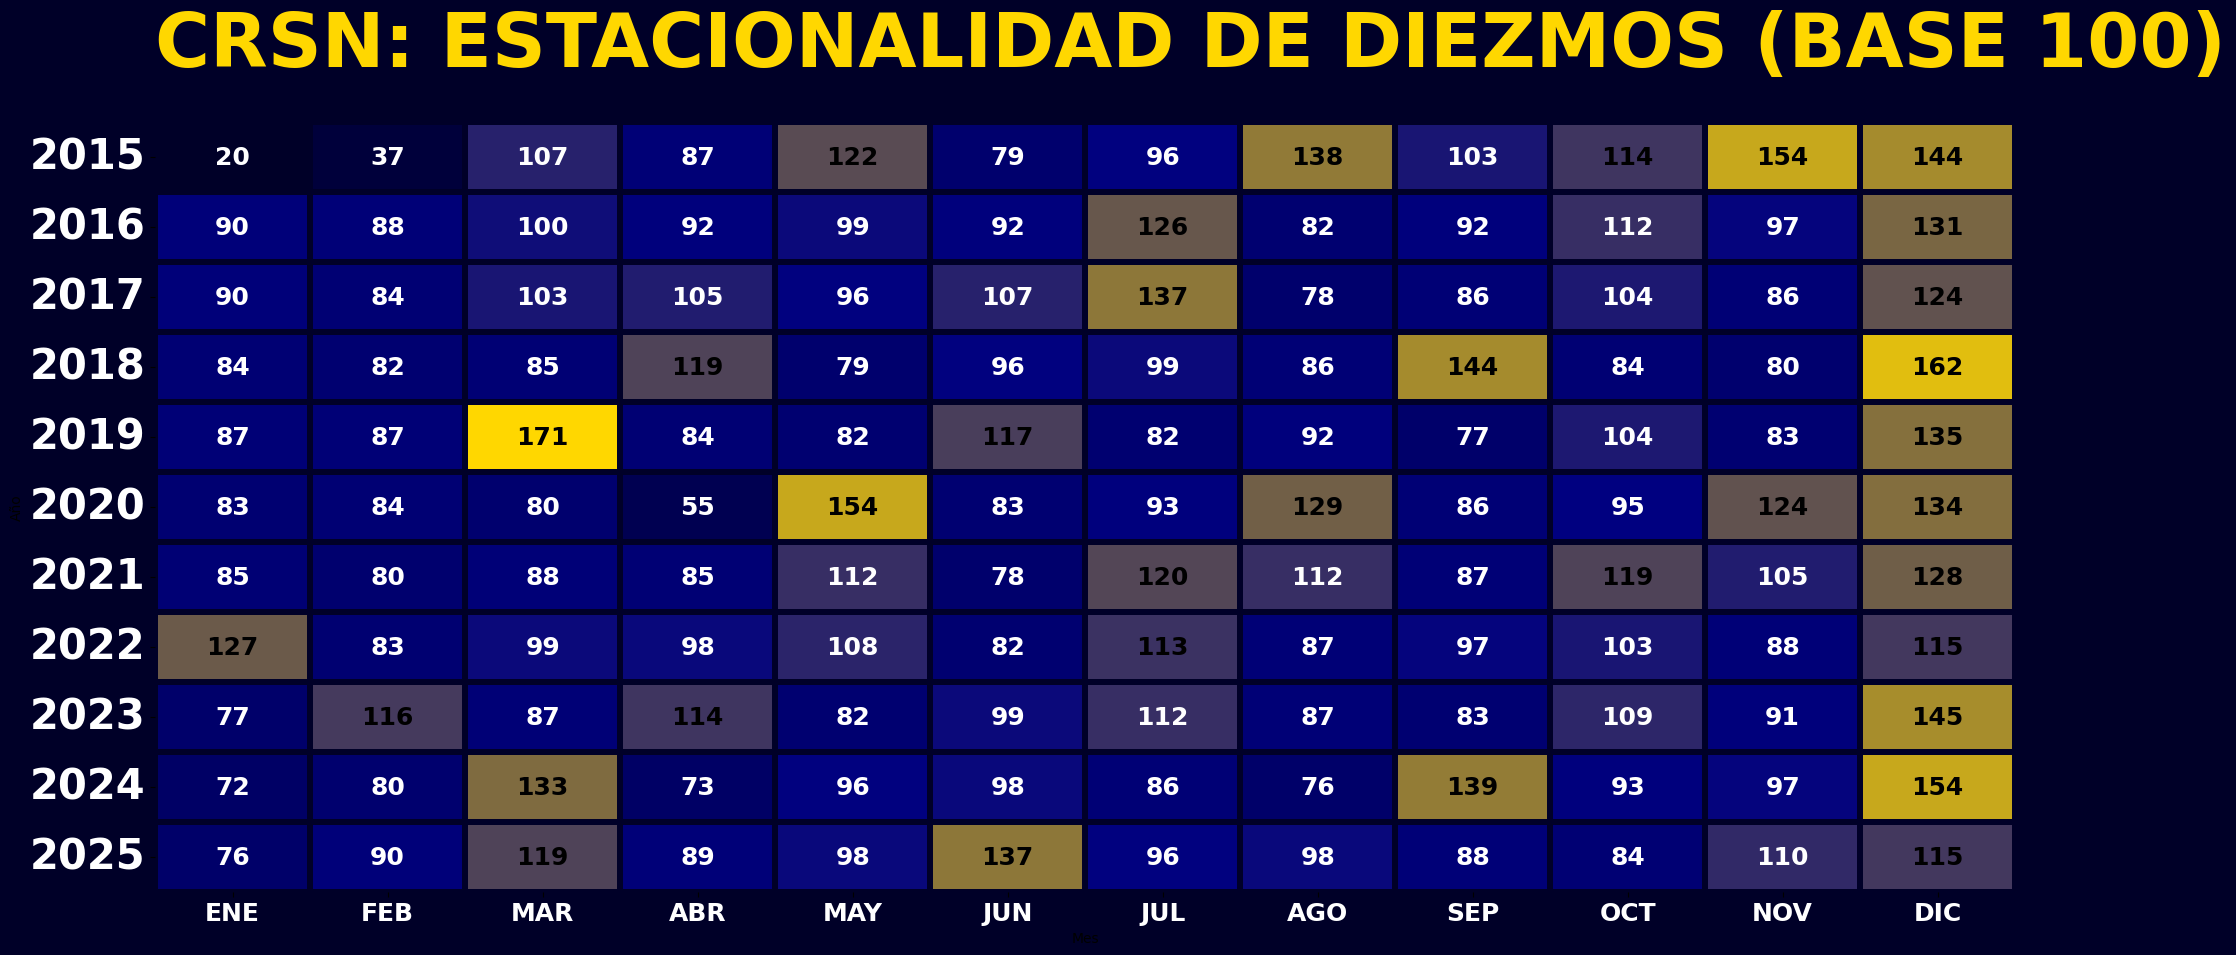

✅ Bloque #2 COMPLETADO | Años en tamaño 30


In [ ]:
# -----------------------------------------------------------------------------
# Autor:       Pedro J. Lancheros / Peter Boat
# Fecha:       2026-01-30 | Hora Bogotá: 23:50 (-5 UTC)
# Versión:     v26.57 (Starlink Grade: Unified Axis & Data Typography)
# Bloque:      #2 - Visual Heatmap (CRSN High Contrast)
# Proyecto:    CRSN (crsn-slides-2015-2025)
# -----------------------------------------------------------------------------

"""
Renderiza el mapa de calor con años y meses en tamaño ejecutivo.
Implementa la 'Lógica Antagónica' para legibilidad total sobre el Oro Vital.
Renders the heatmap with years and months in executive size.
Implements 'Antagonistic Logic' for total readability over Vital Gold.
"""

def render_heatmap_starlink_v26_57(df):
    # 1. PREPARACIÓN
    df_p = df.pivot(index='Año', columns='Mes', values='COP')
    meses_ord = ["ENE", "FEB", "MAR", "ABR", "MAY", "JUN", "JUL", "AGO", "SEP", "OCT", "NOV", "DIC"]
    df_p = df_p[meses_ord]
    df_norm = (df_p.div(df_p.mean(axis=1), axis=0) * 100).round(0).astype(int)

    # 2. LIENZO ULTRA-PANORÁMICO
    plt.figure(figsize=(24, 10), facecolor=PJLA_STYLE["bg"])
    cmap_crsn = LinearSegmentedColormap.from_list("CRSN", [PJLA_STYLE["bg"], "#000080", PJLA_STYLE["oro"]])

    ax = sns.heatmap(df_norm, annot=True, fmt="d", cmap=cmap_crsn, cbar=False,
                     linewidths=3, linecolor=PJLA_STYLE["bg"],
                     annot_kws={"weight": "black", "size": 18, "fontname": PJLA_STYLE["font"]})

    # 3. LÓGICA ANTAGÓNICA
    for text in ax.texts:
        val = int(text.get_text())
        text.set_color("black" if val > 112 else "white")

    # 4. TÍTULO Y EJES (AÑOS IGUALADOS A DATA)
    plt.title("CRSN: ESTACIONALIDAD DE DIEZMOS (BASE 100)",
              color=PJLA_STYLE["oro"], fontsize=PJLA_STYLE["sizes"]["title"],
              pad=40, fontweight='black', loc='left')

    # Ejes en tamaño Data (30) para simetría total
    plt.xticks(color=PJLA_STYLE["white"], fontsize=PJLA_STYLE["sizes"]["axis"], fontweight='bold')
    plt.yticks(color=PJLA_STYLE["white"], fontsize=PJLA_STYLE["sizes"]["data"], fontweight='bold', rotation=0)

    # 5. PERSISTENCIA
    IMG_NAME = f"{TIMESTAMP}_crsn_heatmap_v26_57.png"
    PATH_OUT = os.path.join(OUTPUT_FOLDER, IMG_NAME)
    plt.savefig(PATH_OUT, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Bloque #2 COMPLETADO | Años en tamaño {PJLA_STYLE['sizes']['data']}")
    return PATH_OUT

path_heatmap = render_heatmap_starlink_v26_57(df_master)

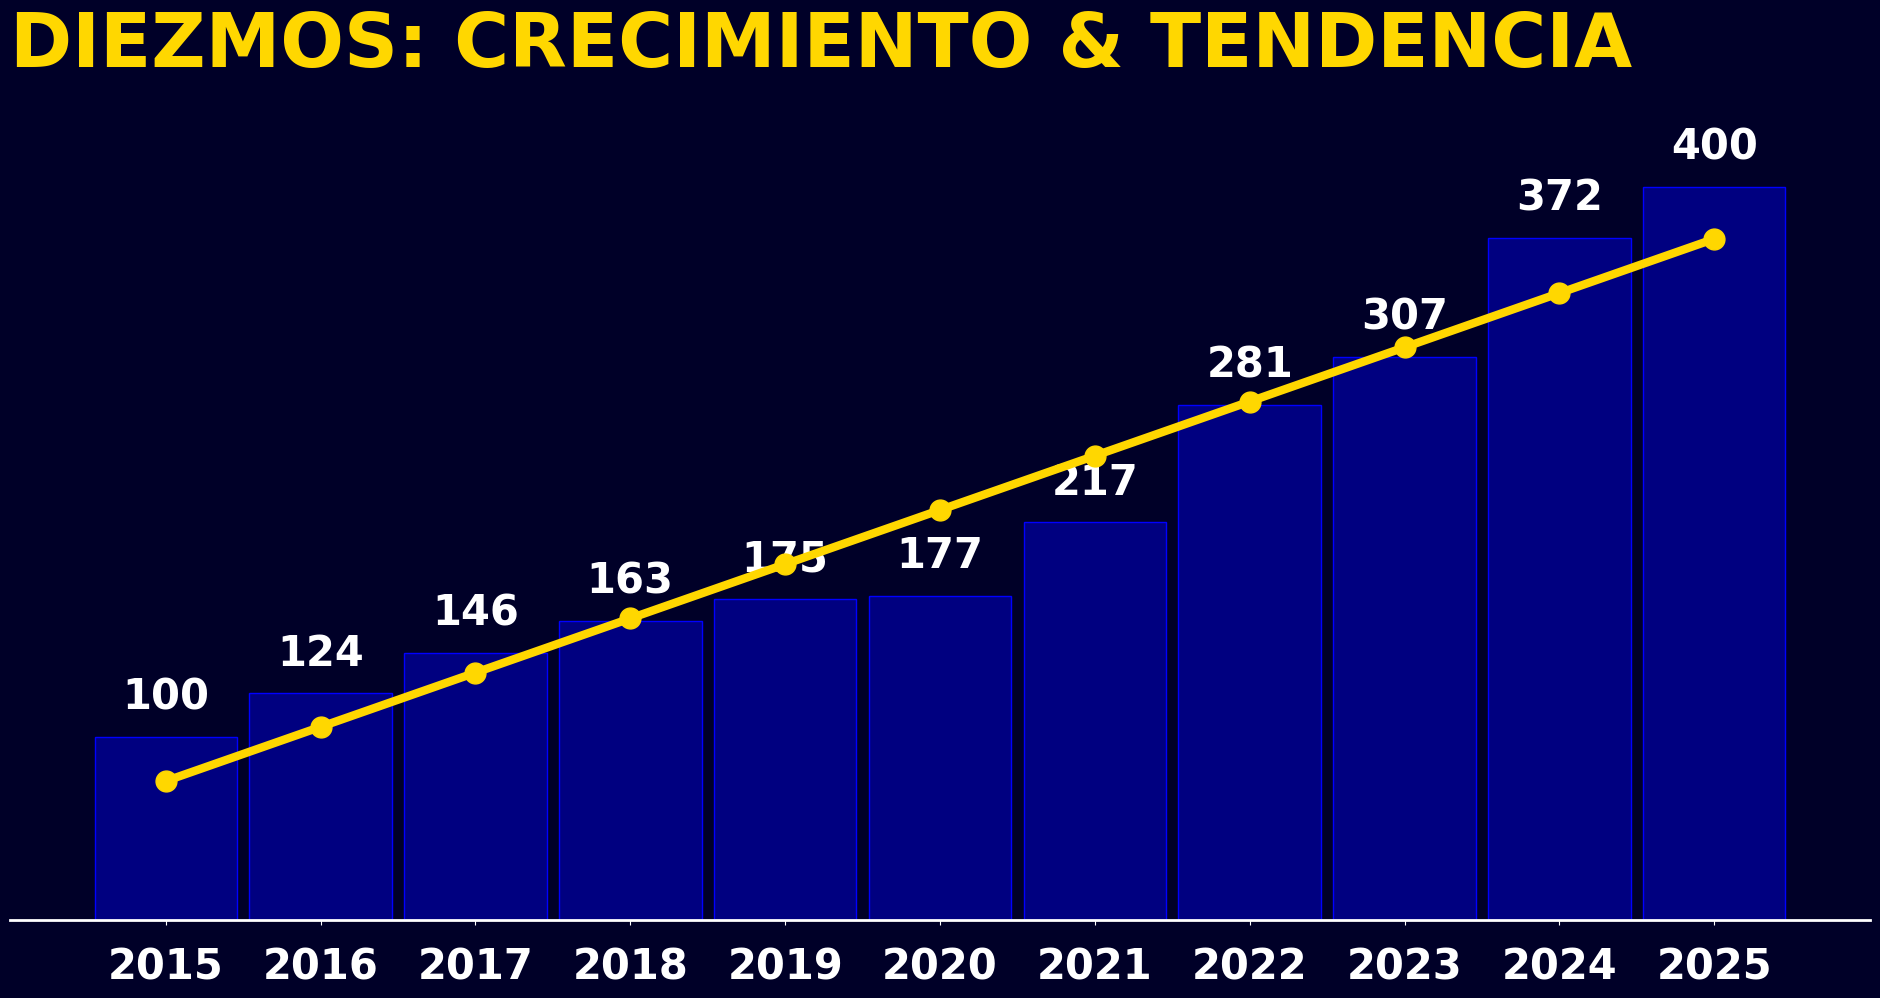

✅ Bloque #3 COMPLETADO | Simetría Años/Data (Size: 30)


In [ ]:
# -----------------------------------------------------------------------------
# Autor:       Pedro J. Lancheros / Peter Boat
# Proyecto:    CRSN (crsn-slides-2015-2025)
# Bloque:      #3 - Crecimiento & Tendencia (Unified Font Scale)
# Versión:     v26.57 (Starlink Grade: Axis Size = Data Label Size)
# -----------------------------------------------------------------------------

"""
Visualiza el crecimiento con los años del eje X escalados al mismo tamaño
que las etiquetas de datos (30 pts). Mantiene la línea de tendencia Oro Líquido.
Visualizes growth with X-axis years scaled to the same size as data labels (30 pts).
Maintains the Liquid Gold trendline.
"""

def render_growth_starlink_v26_57(df):
    # 1. DATA
    ann = df.groupby('Año')['COP'].sum()
    idx = (ann / ann.iloc[0] * 100).round(0).astype(int)
    x = np.arange(len(idx))
    trend = np.poly1d(np.polyfit(x, idx.values, 1))

    # 2. LIENZO (95% WIDTH)
    plt.figure(figsize=(24, 10), facecolor=PJLA_STYLE["bg"])
    ax = plt.gca()

    # Barras Navy
    bars = ax.bar(idx.index.astype(str), idx, color="#000080",
                  edgecolor="#0000FF", linewidth=1, width=0.92)

    # Tendencia Oro Líquido
    plt.plot(idx.index.astype(str), trend(x), color=PJLA_STYLE["oro"],
             linewidth=6, marker='o', markersize=15, zorder=5)

    # 3. DATA LABELS (30 pts)
    for b in bars:
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + 15,
                f"{int(b.get_height())}", ha='center', color=PJLA_STYLE["white"],
                fontsize=PJLA_STYLE["sizes"]["data"], fontweight='black')

    # 4. TÍTULO Y CONFIGURACIÓN DE EJES
    plt.title("DIEZMOS: CRECIMIENTO & TENDENCIA",
              color=PJLA_STYLE["oro"], fontsize=PJLA_STYLE["sizes"]["title"],
              pad=60, fontweight='black', loc='left')

    # EJE X: AÑOS ESCALADOS A 30 PTS (Mismo que Data Labels)
    ax.spines['bottom'].set_color(PJLA_STYLE["white"])
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='x', colors=PJLA_STYLE["white"], labelsize=PJLA_STYLE["sizes"]["data"], pad=15)
    plt.xticks(fontweight='black') # Extra bold para los años

    # Limpieza de ruido
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_visible(False)

    # 5. PERSISTENCIA
    IMG_NAME = f"{TIMESTAMP}_crsn_growth_v26_57.png"
    PATH_OUT = os.path.join(OUTPUT_FOLDER, IMG_NAME)
    plt.savefig(PATH_OUT, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Bloque #3 COMPLETADO | Simetría Años/Data (Size: {PJLA_STYLE['sizes']['data']})")
    return PATH_OUT

path_growth = render_growth_starlink_v26_57(df_master)

In [ ]:
# -----------------------------------------------------------------------------
# Autor:       Pedro J. Lancheros / Peter Boat
# Proyecto:    CRSN (crsn-slides-2015-2025)
# Bloque:      #4 - Reporte de Auditoría de Activos
# Fecha:       2026-01-30 | Hora Bogotá: 23:05 (-5 UTC)
# Versión:     v26.58 (Standard: Physical Path Verification)
# -----------------------------------------------------------------------------

def audit_crsn_production_v26_58():
    print("═"*70)
    print(f"🧐 AUDITORÍA DE PRODUCCIÓN CRSN | SESIÓN: {TIMESTAMP}")
    print(f"📂 RUTA EN DRIVE: My Drive > 01_projects > ... > {os.path.basename(OUTPUT_FOLDER)}")
    print("═"*70)

    if not os.path.exists(OUTPUT_FOLDER):
        print("❌ Error: La carpeta de producción no existe.")
        return

    files = sorted([f for f in os.listdir(OUTPUT_FOLDER)])

    print(f"{'#':<3} | {'ARCHIVO':<45} | {'PESO':<10}")
    print("-" * 70)

    for i, f in enumerate(files, 1):
        f_path = os.path.join(OUTPUT_FOLDER, f)
        size_kb = os.path.getsize(f_path) / 1024
        print(f"{i:<3} | {f:<45} | {size_kb:>7.1f} KB")

    print("═"*70)
    print(f"✅ Todos los archivos han sido persistidos en tu Google Drive.")

audit_crsn_production_v26_58()

══════════════════════════════════════════════════════════════════════
🧐 AUDITORÍA DE PRODUCCIÓN CRSN | SESIÓN: 20260130_2252
📂 RUTA EN DRIVE: My Drive > 01_projects > ... > PRODUCCION_20260130_2252
══════════════════════════════════════════════════════════════════════
#   | ARCHIVO                                       | PESO      
----------------------------------------------------------------------
1   | 20260130_2252_crsn_growth_v26_57.png          |   288.1 KB
2   | 20260130_2252_crsn_heatmap_v26_57.png         |   644.7 KB
3   | 20260130_2252_df_diezmos_master.csv           |     2.8 KB
══════════════════════════════════════════════════════════════════════
✅ Todos los archivos han sido persistidos en tu Google Drive.
